In [1]:
import csv 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import multiprocessing
import numpy as np
import os
import pandas as pd 
from pathlib import Path
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import torch
import torchaudio as ta 
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import utils 
import warnings

#### Filename structure:

6229: Soundtrap#6229

22: 2022

08: August

21: Hour of day(?)

x: Iterator(?)

In [2]:
# Ignore userwarnings due to TorchAudio deprecating in next major release (2.9.0, late 2025).
warnings.filterwarnings("ignore", category=UserWarning)

# Path setup.
root_folder = Path().resolve().parents[0]
data_path = root_folder / "data_dryad" / "Aug_6229"
graph_path = root_folder / "bsc_project" / "graphs"

# sample_name = "6229.220802160000.wav"
sample_name = data_path / "6229.220802160000.wav"
# sample_name = data_path / "6229.220802162000.wav"
sample_wav = os.path.join(data_path, sample_name)

In [3]:
metadata = ta.info(sample_wav)
print(metadata)

AudioMetaData(sample_rate=64000, num_frames=17279744, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [4]:
waveform, sample_rate = ta.load(sample_wav)

#### Audio data:
- 64 kHz: higher resolution than common sound (16 kHz).
- 1 channel with 17 million frames.
- time = num_frames / sample_rate $\approx$ 4.5 mins.

#### Basic waveform plot
Runs very slowly because of the high resolution.

Based on https://docs.pytorch.org/audio/stable/tutorials/audio_io_tutorial.html

In [5]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_ax = torch.arange(0, num_frames) / sample_rate

    fig, ax = plt.subplots(num_channels, 1)
    ax.plot(time_ax, waveform[0], linewidth=1, color="royalblue", alpha=0.8)
    ax.grid(True)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    fig.suptitle("Waveform")

In [6]:
# plot_waveform(waveform, sample_rate)

#### Faster waveform plot
Only designed for for mono-channel audio.

In [7]:
def plot_waveform_fast(waveform, sample_rate, max_pts:int=30_000, title:str="Waveform", ax=None):
    n_channels, n_frames = waveform.shape
    # Truncation steps only for visualizing waveforms.
    stride = max(1, n_frames // max_pts) 
    wf_visual = waveform[:, ::stride]
    # Time in seconds: time = frames / sample_rate and strides are frames divided by steps.  
    t = torch.arange(wf_visual.shape[1], dtype=torch.float32) * (stride / sample_rate) 

    wf_visual = wf_visual.cpu().numpy()
    t = t.cpu().numpy()

    if ax is None: 
        fig, ax = plt.subplots(figsize=(10, 3))
    else: 
        fig = None

    ax.plot(t, wf_visual[0], linewidth=1, color="royalblue", alpha=0.8)
    ax.grid(True, linewidth=0.5, alpha=0.5)
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    
    return fig, ax 

(<Figure size 1000x300 with 1 Axes>,
 <Axes: title={'center': 'Waveform'}, xlabel='Time (seconds)', ylabel='Amplitude'>)

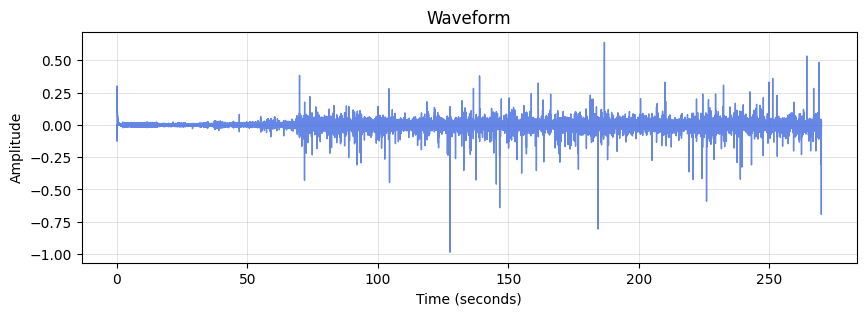

In [8]:
plot_waveform_fast(waveform, sample_rate)

#### Data loader
- Based on https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html.
- Set indices for a data subset when developing.

In [9]:
batch_size = 2
dataset = utils.AudioDataset(data_path, target_sr=sample_rate, max_secs=None)
start_idx = 0 # Create a data subset to skip to later recordings.
end_idx = len(dataset)
subset = Subset(dataset, range(start_idx, end_idx))
loader = DataLoader(subset, batch_size=batch_size, shuffle=False, collate_fn=utils.max_len_collate) # Only shuffle data when training.

Manually checked data subset up to index $=9 \cdot 40$.

In [10]:
# max_points = 30_000
# rows, cols = 3, 3
# fig, axes = plt.subplots(rows, cols, figsize=(12, 9))
# axes = axes.flatten()
# n_plots = rows * cols 

# file_list = []
# i = 0
# for waves, srs, paths, lengths in loader:
#     for w, sr, path, l in zip(waves, srs, paths, lengths):
#         if i >= n_plots:
#             break
#         p = Path(path).name
#         L = int(l) if hasattr(l, "item") else int(l)
#         waveclip = w[:, :L].detach().cpu()
#         plot_waveform_fast(waveclip, sr, max_points, title=p, ax=axes[i])
#         file_list.append(p)
#         i += 1
#     if i >= n_plots:
#         break 

# plt.tight_layout()
# plt.show()

### Notes
- Every .wav file seems to begin with 1 second of noise.

#### Notable files
'6229.220802160000.wav', '6229.220802162000.wav', '6229.220802164000.wav', '6229.220804080000.wav', '6229.220805090000.wav', '6229.220805094000.wav', '6229.220805100000.wav', '6229.220805102000.wav', '6229.220805104000.wav', '6229.220805110000.wav', '6229.220805112000.wav', '6229.220805114000.wav', '6229.220806052000.wav', '6229.220806184000.wav'

#### Find interesting waveforms with high amplitudes
- Skip the first corrupted seconds. 
- Find waveforms with peaks and fractions of their wave length above amplitude peak $0.3$ and length fraction $5e-6$ (a fraction of a million).

In [11]:
skip_secs = 2
ampl_threshold = 0.3
ampl_frac = 5e-6

In [12]:
# max_points = 30_000
# rows, cols = 3, 2
# num_plots = rows*cols
# fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
# axes = axes.flatten()

# wavelist = []
# n_plts = 0
# for waves, srs, paths, lengths in loader:
#     for w, sr, path, l in zip(waves, srs, paths, lengths):
#         if n_plts >= num_plots:
#             break 

#         n_chans, n_frames = w.shape 
#         s_idx = int(sr * skip_secs)
#         waveclip = w[:, :l]
#         waveclip[:, :s_idx] = 0 # Mute the first corrupted seconds of every recording.
#         wavepeak = float(waveclip.abs().max().item())
#         wavefrac = float((waveclip.abs() >= ampl_threshold).float().mean().item())
#         if wavefrac >= ampl_frac and wavepeak >= ampl_threshold:
#             p = Path(path).name
#             wavelist.append((path))
#             plot_waveform_fast(waveclip, sr, max_points, title=p, ax=axes[n_plts])
#             n_plts += 1 

#     if n_plts >= num_plots:
#         break 
# plt.savefig(fname=graph_path / "waveforms_graph.png", dpi=300)
# plt.tight_layout()
# plt.show()

#### Spectrograms

In [13]:
def plot_specgram(waveform, sample_rate, title:str="Spectrogram", ax=None):
    
    n_channels, n_frames = waveform.shape
    wf = waveform.numpy()

    if ax is None: 
        fig, ax = plt.subplots(n_channels, 1, figsize=(7,6))
    else: 
        fig = None

    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Frequency")
    ax.specgram(wf[0], Fs=sample_rate, scale_by_freq=True)
    ax.set_title(title)

    return fig, ax

In [14]:
# sample_name = '6229.220806184000.wav'
# sample_name = "6229.220802162000.wav"
sample_name = "6229.220802160000.wav"
sample_wav = os.path.join(data_path, sample_name)
waveform, sample_rate = ta.load(sample_wav)
# plot_specgram(waveform, sample_rate, title=r"Spectrogram: " + sample_name)

#### Spectrograms
- x-axis: time (seconds).
- y-axis: magnitude of the frequency spectrum calculated using Fourier transform. 
- Frequency: the number of occurring mechanical waves of pressure (the definition of sound) per unit of time. 

In [15]:
def plot_nm_specgrams(n_rows:int, m_cols:int, wavelist:list):
    fig, axes = plt.subplots(n_rows, m_cols, figsize=(9, 9))
    axes = axes.flatten()

    for i, wav in enumerate(wavelist):
        p = Path(wav)
        wav_file = os.path.join(data_path, sample_name)
        wf, sr = ta.load(wav_file)
        plot_specgram(wf, sr, title=p.name, ax=axes[i])

    plt.savefig(fname=graph_path / "spectro_graph.png", bbox_inches='tight', pad_inches=0.2, dpi=300)
    plt.tight_layout()
    plt.show()

#### Compute stats
Iterate through entire dataset instead of plotting first waveforms encountered above the thresholds.

In [16]:
def compute_stats(w, sr, length, skip_secs):
            n_chans, n_frames = w.shape 
            empty_dict = dict(duration_sec = 0, peak=0.0, mean_abs=0.0, rms=0.0, zcr_hz=0.0)
            if n_frames <= 0:
                   return empty_dict

            s_idx = (sr * skip_secs)
            s_idx = min(max(s_idx, 0), n_frames) # Ensure no 0 length files. 
            wf = w[:, :n_frames].clone()
            if s_idx > 0:
                wf[:, :s_idx] = 0.0 # Mute first corrupted seconds.
            
            # Duration in seconds.
            duration_sec = max((n_frames - s_idx) / float(sr), 0.0)

            # Wave without the muted clip.
            wclip = wf[:, s_idx:] if s_idx < n_frames else wf[:, :0]

            if wclip.numel() == 0:
                  return empty_dict

            peak = wclip.abs().amax(dim=1).amax().item()
            mean_abs = wclip.abs().mean().item()
            # Root mean square.
            rms = torch.sqrt((wclip**2).mean().item())
            # Zero-Crossing Rate.
            silence_band = 10e-12
            wclip_nz = torch.where(wclip == 0, torch.tensor(silence_band, device=wclip.device), wclip)
            signs = torch.signbit(wclip_nz)

            if wclip.shape[1] >= 2:
                  zc = (signs[:, 1:] ^ signs[:, :-1].sum().item())
                  zcr_hz = (zc / (wclip_nz.shape[1] - 1)) * sr
            else:
                  zcr_hz = 0.0

            return dict(
                  duration_sec = float(duration_sec),
                  peak = float(peak),
                  mean_abs = float(mean_abs),
                  rms = float(rms),
                  zcr_hz = float(zcr_hz)
            )

In [17]:
# stats_rows = []
# for waves, srs, paths, lengths in loader:
#     for w, sr, path, l in zip(waves, srs, paths, lengths):
#         stats = compute_stats(w, sr, l, skip_secs)
#         stats_rows.append({
#                "filename": Path(path).name,
#                **stats
#         })

# # Save to permanent CSV file.
# fname = "august_stats.csv"
# stats_folder = Path().resolve() / "data_management"
# with open(stats_folder / fname, "w", newline='') as f:
#     cols = ["filename", "duration_sec", "peak", "mean_abs", "rms", "zcr_hz"]
#     writer = csv.DictWriter(f, fieldnames=cols)
#     writer.writeheader()
#     writer.writerows(stats_rows)

# stats_df = pd.read_csv(stats_folder / fname)
# stats_df = stats_df.sort_values(by=["mean_abs", "peak"], ascending=False).reset_index(drop=True)
# stats_df.to_csv(path_or_buf=stats_folder / fname, index=False)

In [18]:
# cand_waves = stats_df["mean_abs"].tolist()
# plot_nm_specgrams(3, 3, cand_waves[:9])

#### k-means++

In [19]:
seed = 104 # Constant random seed for clustering initialization.
k = 8
b = 256 * multiprocessing.cpu_count() # Batch size for 12 logical cores.
batch_kmeans = MiniBatchKMeans(
    n_clusters=k,
    init="k-means++",
    n_init=10,
    batch_size=b,
    max_iter=100,
    random_state=seed
)

##### Build X (no optimizations)

In [20]:
# # def tensor_to_x()
# target_len = int(sample_rate * 60 * 4.5) # sample rate * time = n frames = 17,280,000.
# max_pts = 100
# rows, ids = [], []
# for pad_waves, srs, paths, lengths in loader:
#     B, C, T = pad_waves.shape # Iterate over batches: batch size, channels, n frames.
#     for b in range(B):
#         sr = int(srs[b])
#         s_idx = int(sr * float(skip_secs))
#         L = int(lengths[b].item())
#         w = pad_waves[b, :, :L]

#         if s_idx < w.numel():
#             w = w[:, s_idx:]
#         else: 
#             continue 
#         # Padding needed at dataset level to build X (data loader pads at batch-level).
#         if w.numel() >= target_len:
#             w = w[:target_len]
#         else:
#             w = F.pad(w, (0, target_len - w.numel()))
        
#         rows.append(w)
#         ids.append(Path(paths[b]).name)

# # Concatenate rows into X.
# # X: (n samples, n features.)
# X = torch.cat(rows, dim=0).to(torch.float32)
# # return X, ids 

##### Build X (truncating with strides)

In [21]:
def tensor_to_reduced_x(loader, max_pts, skip_secs, dtype=torch.float32):
    rows, ids = [], []
    for pad_waves, srs, paths, lengths in loader:
        B = pad_waves.shape[0] # Iterate over batches: batch size, channels, n frames.
        for b in range(B):
            sr = int(srs[b])
            s_idx = int(sr * float(skip_secs))
            L = int(lengths[b].item())

            if s_idx >= L:
                continue 
            
            w = pad_waves[b, 0, :L]
            w = w[s_idx:]

            # Downsample to max_pts using fixed indices.
            n_elms = w.numel()
            if n_elms == 0:
                continue
            if n_elms >= max_pts:
                k = torch.arange(max_pts, device=w.device)
                idx = torch.floor(k.to(torch.float32) * (n_elms / float(max_pts))).to(torch.long)
                w_small = w.index_select(0, idx)
            else:
                # Padding needed at dataset level to build X (data loader pads at batch-level).
                w_small = F.pad(w, (0, max_pts - n_elms))

            rows.append(w_small.unsqueeze(0).to(dtype))
            ids.append(Path(paths[b]).name)

    # Concatenate rows into X.
    # X: (n samples, n features.)
    X = torch.cat(rows, dim=0).to(torch.float32)
    return X, ids 

In [22]:
X, ids = tensor_to_reduced_x(loader, max_pts=5000, skip_secs=2, dtype=torch.float32)

#### k-means clustering without preprocessing

In [38]:
# X_l1 = normalize(X, norm="l1", axis=1)
batch_kmeans.fit(X)
kbm_labels = batch_kmeans.labels_
kbm_centers = batch_kmeans.cluster_centers_ 
kbm_inertia = batch_kmeans.inertia_
kbm_silhs = silhouette_score(X, kbm_labels)

In [39]:
pca_reducer = PCA(n_components=2, random_state=seed)
Z = pca_reducer.fit_transform(X)
Z_centers = pca_reducer.transform(kbm_centers)

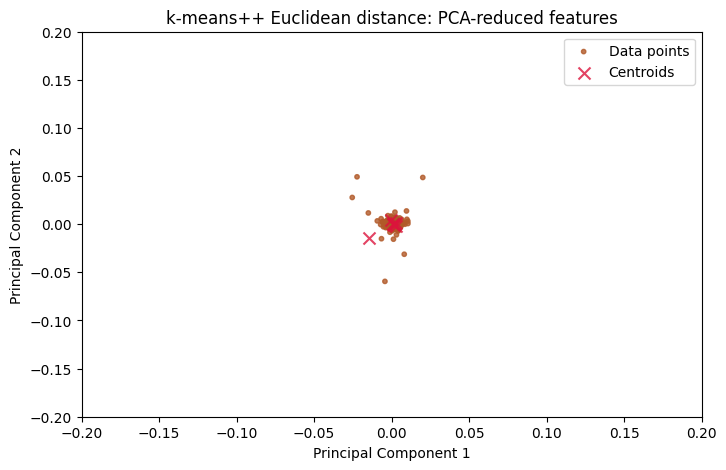

In [40]:
cmap = mpl.colormaps.get_cmap("Paired")

fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(Z[:, 0], Z[:, 1], c=kbm_labels, cmap=cmap, s=10, alpha=0.8, label="Data points")
ax.scatter(Z_centers[:, 0], Z_centers[:, 1], c="crimson", alpha=0.8, s=75, marker="x", label="Centroids")
# ax.plot(kbm_inertia, marker="o", lw=2, c="mediumseagreen", alpha=0.8, label="Inertia")
# ax.plot(kbm_silhs, marker="o", lw=2, c="cornflowerblue", alpha=0.8, label="Silhouette score")

ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
ax.set_title("k-means++ Euclidean distance: PCA-reduced features")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")

ax.legend()
plt.show()

#### k-means with cosine clustering
- L2-normalization.
- Cosine distance approximates Euclidean on the unit sphere.

In [26]:
X_unit = normalize(X, norm="l2", axis=1)
batch_kmeans.fit(X_unit)
unit_labels = batch_kmeans.labels_
unit_centers = batch_kmeans.cluster_centers_
unit_inertia = batch_kmeans.inertia_
unit_silhs = silhouette_score(X_unit, unit_labels)

In [27]:
Z_unit = pca_reducer.fit_transform(X_unit)
Z_centers_unit = pca_reducer.transform(unit_centers)

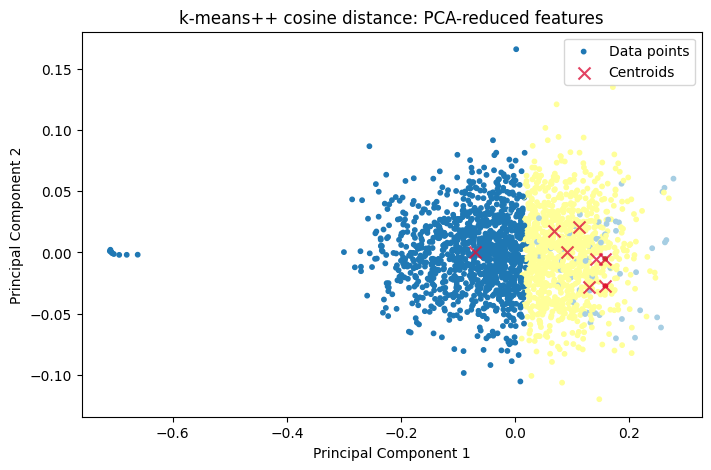

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(Z_unit[:, 0], Z_unit[:, 1], cmap=cmap, c=unit_labels, s=10, alpha=1, label="Data points")
ax.scatter(Z_centers_unit[:, 0], Z_centers_unit[:, 1], c="crimson", alpha=0.8, s=75, marker="x", label="Centroids")
# ax.plot(unit_inertia, marker="o", lw=2, c="mediumseagreen", alpha=0.8, label="Inertia")
# ax.plot(unit_silhs, marker="o", lw=2, c="cornflowerblue", alpha=0.8, label="Silhouette score")

ax.set_title("k-means++ cosine distance: PCA-reduced features")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")

ax.legend()
plt.show()

#### t-SNE

In [29]:
tsne = TSNE(n_components=2, init="pca", random_state=seed, learning_rate="auto")
Z_tsne = tsne.fit_transform(X)

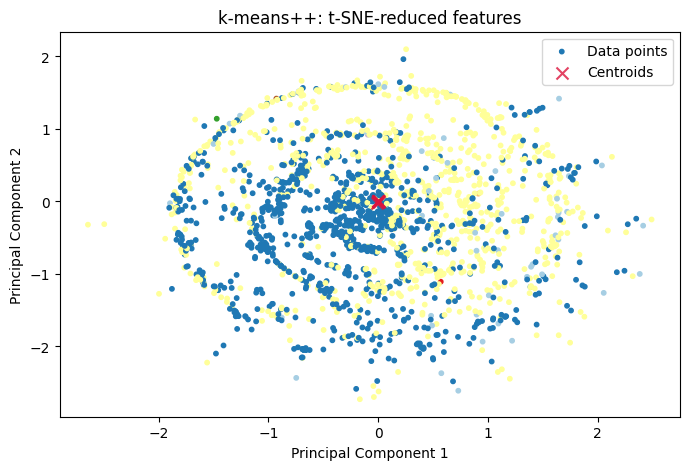

In [30]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(Z_tsne[:, 0], Z_tsne[:, 1], cmap=cmap, c=unit_labels, s=10, alpha=1, label="Data points")
ax.scatter(Z_centers[:, 0], Z_centers[:, 1], c="crimson", alpha=0.8, s=75, marker="x", label="Centroids")
# ax.plot(unit_inertia, marker="o", lw=2, c="mediumseagreen", alpha=0.8, label="Inertia")
# ax.plot(unit_silhs, marker="o", lw=2, c="cornflowerblue", alpha=0.8, label="Silhouette score")

ax.set_title("k-means++: t-SNE-reduced features")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")

ax.legend()
plt.show()

#### Cluster algorithm notes
- The critical runtime variable is the number of frames which can be reduced with strides.